<a href="https://colab.research.google.com/github/odmina/misbehaving_armadillos/blob/main/2021_07_14_SST-1B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Overview
The following notebook loads data from single behavioral session (one mouse) and one imaging experiment (just one plane) associated with that session to plot stimulus, licks and reward data and neural activity (one selected neuron). 

# Set up environment and import packages

We have built a package called `mindscope_utilities` which contains some useful convenience functions. The `allenSDK` is a dependency of this package and will be automatically installed when you install `mindscope_utilities` per the instrutions below.

We will first install `mindscope_utilities` into our colab environment by running the commands below. When this cell is complete, click on the `RESTART RUNTIME` button that appears at the end of the output. Note that running this cell will produce a long list of outputs and some error messages. Clicking `RESTART RUNTIME` at the end will resolve these issues. 

You can minimize the cell after you are done to hide the output. 

#### Install necessary packages

In [1]:
!python -m pip install --upgrade pip
!pip install mindscope_utilities --upgrade

     |████████████████████████████████| 1.6MB 4.3MB/s 
  Found existing installation: pip 19.3.1
    Uninstalling pip-19.3.1:
      Successfully uninstalled pip-19.3.1
     |████████████████████████████████| 73 kB 1.2 MB/s 
     |████████████████████████████████| 1.7 MB 27.4 MB/s 
     |████████████████████████████████| 10.4 MB 49.8 MB/s 
     |████████████████████████████████| 3.4 MB 50.1 MB/s 
     |████████████████████████████████| 1.3 MB 49.5 MB/s 
     |████████████████████████████████| 47.4 MB 31 kB/s 
     |████████████████████████████████| 54 kB 2.5 MB/s 
     |████████████████████████████████| 98 kB 6.6 MB/s 
     |████████████████████████████████| 149 kB 77.4 MB/s 
     |████████████████████████████████| 42 kB 1.2 MB/s 
     |████████████████████████████████| 668 kB 43.0 MB/s 
     |████████████████████████████████| 3.4 MB 42.6 MB/s 
     |████████████████████████████████| 4.3 MB 35.0 MB/s 
     |████████████████████████████████| 20.1 MB 1.3 MB/s 
     |██████████████████████

#### Next we will import packages we need later in the notebook

In [1]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

import mindscope_utilities
import mindscope_utilities.visual_behavior_ophys as ophys

from allensdk.brain_observatory.behavior.behavior_project_cache import VisualBehaviorOphysProjectCache

pd.set_option('display.max_columns', 500)

# Load the session and experiment summary tables

We download the data cache:

- `ophys_session_table` contains data describing imaging sessions - one session can contain more than one imaging experiment (more than one plane), and not all behavioral session are accompanied by imaging. contains metadata describing imaging sessions. If more than one plane was imaged during a session, one ophys session id will be associated multiple *ophys experiment ids*. Each ophys session id will also have a unique *behavior session id*
- `behavior_session_table` contains metadata describing behavioral sessions, which may or may not be during imaging. Behavior session ids that do not have *ophys session ids* were training sessions
- `ophys_experiment_table` contains metadata describing imaging experiments (aka imaging planes). When mesoscope is used, one ophys session may contain up to 8 unique experiments (two visual areas by four imaging depths). Some imaging planes may not be released due to quality control issues, thus each ophys session id is associated with anywhere from one to eight unique *experiment ids*. Ophys experiment ids are unique and do not repeat across sessions. To find the same imaging plane that was matched across multiple sessions, use the *ophys_container_id* column that can be found in both ophys_session_table and ophys_experiment_table

In [2]:
data_storage_directory = "/temp" # Note: this path must exist on your local drive
cache = VisualBehaviorOphysProjectCache.from_s3_cache(cache_dir=data_storage_directory)

ophys_session_table.csv: 100%|██████████| 165k/165k [00:00<00:00, 966kMB/s]  
behavior_session_table.csv: 100%|██████████| 885k/885k [00:00<00:00, 4.70MMB/s] 
ophys_experiment_table.csv: 100%|██████████| 336k/336k [00:00<00:00, 1.76MMB/s] 


Then we can access the session and experiment tables directly.

Note that a 'session' is a single behavioral session. Sessions that are performed on the mesoscope will have multiple (up to 8) 'experiments' associated with them, where an experiment is a distinct imaging plane. 

In [3]:
session_table = cache.get_ophys_session_table()
experiment_table = cache.get_ophys_experiment_table()
behavior_session_table = cache.get_behavior_session_table()

We can then view the contents of the session table. Note that this contains a lot of useful metadata about each session. One of the columns, `ophys_experiment_id` provides a list of the experiments (aka imaging planes) that are associated with each session.

In [4]:
session_table.head()

,equipment_name,full_genotype,mouse_id,reporter_line,driver_line,sex,age_in_days,cre_line,indicator,session_number,prior_exposures_to_session_type,prior_exposures_to_image_set,prior_exposures_to_omissions,behavior_session_id,ophys_experiment_id,ophys_container_id,project_code,date_of_acquisition,session_type
ophys_session_id,,,,,,,,,,,,,,,,,,,
951410079,MESO.1,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,457841,Ai148(TIT2L-GC6f-ICL-tTA2),[Sst-IRES-Cre],F,206.0,Sst-IRES-Cre,GCaMP6f,1.0,0,65.0,0,951520319,"[951980471, 951980473, 951980475, 951980479, 9...","[1018028339, 1018028342, 1018028345, 101802835...",VisualBehaviorMultiscope,2019-09-20 09:45:29.897856,OPHYS_1_images_A
952430817,MESO.1,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,457841,Ai148(TIT2L-GC6f-ICL-tTA2),[Sst-IRES-Cre],F,209.0,Sst-IRES-Cre,GCaMP6f,2.0,0,66.0,1,952554548,"[953659743, 953659745, 953659749, 953659752]","[1018028339, 1018028345, 1018028354, 1018028357]",VisualBehaviorMultiscope,2019-09-23 08:13:07.627573,OPHYS_2_images_A_passive
954954402,MESO.1,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,457841,Ai148(TIT2L-GC6f-ICL-tTA2),[Sst-IRES-Cre],F,210.0,Sst-IRES-Cre,GCaMP6f,3.0,0,67.0,2,953982960,"[958527464, 958527471, 958527474, 958527479, 9...","[1018028339, 1018028342, 1018028345, 101802835...",VisualBehaviorMultiscope,2019-09-24 16:00:00.000000,OPHYS_3_images_A
955775716,MESO.1,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,457841,Ai148(TIT2L-GC6f-ICL-tTA2),[Sst-IRES-Cre],F,212.0,Sst-IRES-Cre,GCaMP6f,3.0,1,68.0,3,956010809,"[956941841, 956941844, 956941846]","[1018028339, 1018028342, 1018028345]",VisualBehaviorMultiscope,2019-09-26 08:44:37.199778,OPHYS_3_images_A
957020350,MESO.1,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,457841,Ai148(TIT2L-GC6f-ICL-tTA2),[Sst-IRES-Cre],F,213.0,Sst-IRES-Cre,GCaMP6f,4.0,0,0.0,4,957032492,"[957759562, 957759564, 957759566, 957759570, 9...","[1018028339, 1018028342, 1018028345, 101802835...",VisualBehaviorMultiscope,2019-09-27 08:28:05.415005,OPHYS_4_images_B


The experiment table has one row per experiment. Note that the `ophys_session_id` column links each experiment to its associated session in the session_table.

In [5]:
experiment_table.head()

,equipment_name,full_genotype,mouse_id,reporter_line,driver_line,sex,age_in_days,cre_line,indicator,session_number,prior_exposures_to_session_type,prior_exposures_to_image_set,prior_exposures_to_omissions,ophys_session_id,behavior_session_id,ophys_container_id,project_code,imaging_depth,targeted_structure,date_of_acquisition,session_type,file_id
ophys_experiment_id,,,,,,,,,,,,,,,,,,,,,,
951980471,MESO.1,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,457841,Ai148(TIT2L-GC6f-ICL-tTA2),[Sst-IRES-Cre],F,206.0,Sst-IRES-Cre,GCaMP6f,1.0,0,65.0,0,951410079,951520319,1018028342,VisualBehaviorMultiscope,150,VISp,2019-09-20 09:45:29.897856,OPHYS_1_images_A,1085394308
951980484,MESO.1,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,457841,Ai148(TIT2L-GC6f-ICL-tTA2),[Sst-IRES-Cre],F,206.0,Sst-IRES-Cre,GCaMP6f,1.0,0,65.0,0,951410079,951520319,1018028351,VisualBehaviorMultiscope,75,VISl,2019-09-20 09:45:29.897856,OPHYS_1_images_A,1085400876
951980473,MESO.1,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,457841,Ai148(TIT2L-GC6f-ICL-tTA2),[Sst-IRES-Cre],F,206.0,Sst-IRES-Cre,GCaMP6f,1.0,0,65.0,0,951410079,951520319,1018028345,VisualBehaviorMultiscope,225,VISp,2019-09-20 09:45:29.897856,OPHYS_1_images_A,1085400919
951980479,MESO.1,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,457841,Ai148(TIT2L-GC6f-ICL-tTA2),[Sst-IRES-Cre],F,206.0,Sst-IRES-Cre,GCaMP6f,1.0,0,65.0,0,951410079,951520319,1018028354,VisualBehaviorMultiscope,150,VISl,2019-09-20 09:45:29.897856,OPHYS_1_images_A,1085400977
951980475,MESO.1,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,457841,Ai148(TIT2L-GC6f-ICL-tTA2),[Sst-IRES-Cre],F,206.0,Sst-IRES-Cre,GCaMP6f,1.0,0,65.0,0,951410079,951520319,1018028339,VisualBehaviorMultiscope,75,VISp,2019-09-20 09:45:29.897856,OPHYS_1_images_A,1085400920


Table for Single Plane- VisualBehaviorTask1B dataset
-plot imaging depth and targeted structure




In [6]:
SP_VT1B_table = experiment_table[experiment_table['project_code'] == 'VisualBehaviorTask1B']
SP_VT1B_table.head()

,equipment_name,full_genotype,mouse_id,reporter_line,driver_line,sex,age_in_days,cre_line,indicator,session_number,prior_exposures_to_session_type,prior_exposures_to_image_set,prior_exposures_to_omissions,ophys_session_id,behavior_session_id,ophys_container_id,project_code,imaging_depth,targeted_structure,date_of_acquisition,session_type,file_id
ophys_experiment_id,,,,,,,,,,,,,,,,,,,,,,
993862620,CAM2P.4,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,476970,Ai148(TIT2L-GC6f-ICL-tTA2),[Sst-IRES-Cre],M,194.0,Sst-IRES-Cre,GCaMP6f,1.0,0,39.0,0,993727065,993766500,991913453,VisualBehaviorTask1B,275,VISp,2019-12-11 19:01:03.000000,OPHYS_1_images_B,993906653
994053903,CAM2P.4,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,476970,Ai148(TIT2L-GC6f-ICL-tTA2),[Sst-IRES-Cre],M,195.0,Sst-IRES-Cre,GCaMP6f,2.0,0,40.0,1,993984066,993995204,991913453,VisualBehaviorTask1B,275,VISp,2019-12-12 20:47:45.000000,OPHYS_2_images_B_passive,994098960
994278281,CAM2P.4,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,476970,Ai148(TIT2L-GC6f-ICL-tTA2),[Sst-IRES-Cre],M,196.0,Sst-IRES-Cre,GCaMP6f,3.0,0,41.0,2,994199725,994210659,991913453,VisualBehaviorTask1B,275,VISp,2019-12-13 20:34:10.000000,OPHYS_3_images_B,994320564
994790561,CAM2P.4,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,476970,Ai148(TIT2L-GC6f-ICL-tTA2),[Sst-IRES-Cre],M,199.0,Sst-IRES-Cre,GCaMP6f,3.0,1,42.0,3,994731371,994743822,991913453,VisualBehaviorTask1B,275,VISp,2019-12-16 21:20:41.000000,OPHYS_3_images_B,994831840
994955425,CAM2P.4,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,476970,Ai148(TIT2L-GC6f-ICL-tTA2),[Sst-IRES-Cre],M,200.0,Sst-IRES-Cre,GCaMP6f,4.0,0,0.0,4,994883056,994894518,991913453,VisualBehaviorTask1B,275,VISp,2019-12-17 19:02:07.000000,OPHYS_4_images_A,995003435


In [7]:
SP_VT1B_table.imaging_depth.unique()

array([275, 175, 375])

In [8]:
SP_VT1B_table.targeted_structure.unique()

array(['VISp'], dtype=object)

In [9]:
SP_VT1b_VIP = SP_VT1B_table[SP_VT1B_table['cre_line'] == 'Vip-IRES-Cre']
SP_VT1b_VIP.imaging_depth.unique()

array([175])

In [10]:
SP_VT1b_SST = SP_VT1B_table[SP_VT1B_table['cre_line'] == 'Sst-IRES-Cre']
SP_VT1b_SST.imaging_depth.unique()

array([275])

In [11]:
SP_VT_table = experiment_table[experiment_table['project_code'] == 'VisualBehavior']
SP_VT_table.head()

,equipment_name,full_genotype,mouse_id,reporter_line,driver_line,sex,age_in_days,cre_line,indicator,session_number,prior_exposures_to_session_type,prior_exposures_to_image_set,prior_exposures_to_omissions,ophys_session_id,behavior_session_id,ophys_container_id,project_code,imaging_depth,targeted_structure,date_of_acquisition,session_type,file_id
ophys_experiment_id,,,,,,,,,,,,,,,,,,,,,,
792815735,CAM2P.4,Vip-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,412036,Ai148(TIT2L-GC6f-ICL-tTA2),[Vip-IRES-Cre],F,148.0,Vip-IRES-Cre,GCaMP6f,1.0,0,19.0,1,792619807,792680306,791352433,VisualBehavior,175,VISp,2018-12-10 21:19:50.000000,OPHYS_1_images_A,859887405
795073741,CAM2P.4,Vip-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,412036,Ai148(TIT2L-GC6f-ICL-tTA2),[Vip-IRES-Cre],F,151.0,Vip-IRES-Cre,GCaMP6f,3.0,0,21.0,3,794918442,794968300,791352433,VisualBehavior,175,VISp,2018-12-13 21:11:17.000000,OPHYS_3_images_A,859887459
795953296,CAM2P.4,Vip-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,412036,Ai148(TIT2L-GC6f-ICL-tTA2),[Vip-IRES-Cre],F,152.0,Vip-IRES-Cre,GCaMP6f,4.0,0,0.0,4,795625712,795742990,791352433,VisualBehavior,175,VISp,2018-12-14 20:17:05.000000,OPHYS_4_images_B,859887431
796108483,CAM2P.4,Vip-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,412036,Ai148(TIT2L-GC6f-ICL-tTA2),[Vip-IRES-Cre],F,153.0,Vip-IRES-Cre,GCaMP6f,5.0,0,1.0,5,796044280,796052844,791352433,VisualBehavior,175,VISp,2018-12-15 20:56:37.000000,OPHYS_5_images_B_passive,859888310
796308505,CAM2P.4,Vip-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,412036,Ai148(TIT2L-GC6f-ICL-tTA2),[Vip-IRES-Cre],F,154.0,Vip-IRES-Cre,GCaMP6f,6.0,0,2.0,6,796236521,796251270,791352433,VisualBehavior,175,VISp,2018-12-16 20:44:48.000000,OPHYS_6_images_B,859887448


In [12]:
SP_VT_table.imaging_depth.unique()

array([175, 375, 290, 275])

How many planes were imaged for VIP cells in visual task-Single plane dataset? 


In [13]:
SP_VT_VIP = SP_VT_table[SP_VT_table['cre_line'] == 'Vip-IRES-Cre']
SP_VT_VIP.imaging_depth.unique()

array([175])

How many planes were imaged for sst cells in visual task-Single plane dataset?? 


In [15]:
SP_VT_SST = SP_VT_table[SP_VT_table['cre_line'] == 'Sst-IRES-Cre']
SP_VT_SST.imaging_depth.unique()

array([290, 275])

In [29]:
single_plane_sst = SP_VT1B_table[SP_VT1B_table['cre_line'] == 'Sst-IRES-Cre']
single_plane_sst.head(80)

,equipment_name,full_genotype,mouse_id,reporter_line,driver_line,sex,age_in_days,cre_line,indicator,session_number,prior_exposures_to_session_type,prior_exposures_to_image_set,prior_exposures_to_omissions,ophys_session_id,behavior_session_id,ophys_container_id,project_code,imaging_depth,targeted_structure,date_of_acquisition,session_type,file_id
ophys_experiment_id,,,,,,,,,,,,,,,,,,,,,,
993862620,CAM2P.4,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,476970,Ai148(TIT2L-GC6f-ICL-tTA2),[Sst-IRES-Cre],M,194.0,Sst-IRES-Cre,GCaMP6f,1.0,0,39.0,0,993727065,993766500,991913453,VisualBehaviorTask1B,275,VISp,2019-12-11 19:01:03.000000,OPHYS_1_images_B,993906653
994053903,CAM2P.4,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,476970,Ai148(TIT2L-GC6f-ICL-tTA2),[Sst-IRES-Cre],M,195.0,Sst-IRES-Cre,GCaMP6f,2.0,0,40.0,1,993984066,993995204,991913453,VisualBehaviorTask1B,275,VISp,2019-12-12 20:47:45.000000,OPHYS_2_images_B_passive,994098960
994278281,CAM2P.4,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,476970,Ai148(TIT2L-GC6f-ICL-tTA2),[Sst-IRES-Cre],M,196.0,Sst-IRES-Cre,GCaMP6f,3.0,0,41.0,2,994199725,994210659,991913453,VisualBehaviorTask1B,275,VISp,2019-12-13 20:34:10.000000,OPHYS_3_images_B,994320564
994790561,CAM2P.4,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,476970,Ai148(TIT2L-GC6f-ICL-tTA2),[Sst-IRES-Cre],M,199.0,Sst-IRES-Cre,GCaMP6f,3.0,1,42.0,3,994731371,994743822,991913453,VisualBehaviorTask1B,275,VISp,2019-12-16 21:20:41.000000,OPHYS_3_images_B,994831840
994955425,CAM2P.4,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,476970,Ai148(TIT2L-GC6f-ICL-tTA2),[Sst-IRES-Cre],M,200.0,Sst-IRES-Cre,GCaMP6f,4.0,0,0.0,4,994883056,994894518,991913453,VisualBehaviorTask1B,275,VISp,2019-12-17 19:02:07.000000,OPHYS_4_images_A,995003435
995280513,CAM2P.4,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,476970,Ai148(TIT2L-GC6f-ICL-tTA2),[Sst-IRES-Cre],M,201.0,Sst-IRES-Cre,GCaMP6f,4.0,1,1.0,5,995115654,995142529,991913453,VisualBehaviorTask1B,275,VISp,2019-12-18 19:50:24.000000,OPHYS_4_images_A,995502580
995439942,CAM2P.4,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,476970,Ai148(TIT2L-GC6f-ICL-tTA2),[Sst-IRES-Cre],M,202.0,Sst-IRES-Cre,GCaMP6f,6.0,0,2.0,6,995359867,995379633,991913453,VisualBehaviorTask1B,275,VISp,2019-12-19 21:10:05.000000,OPHYS_6_images_A,995523140
995622557,CAM2P.4,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,476970,Ai148(TIT2L-GC6f-ICL-tTA2),[Sst-IRES-Cre],M,203.0,Sst-IRES-Cre,GCaMP6f,5.0,0,3.0,7,995560574,995570835,991913453,VisualBehaviorTask1B,275,VISp,2019-12-20 18:26:12.000000,OPHYS_5_images_A_passive,995659072
955276580,CAM2P.5,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,470784,Ai148(TIT2L-GC6f-ICL-tTA2),[Sst-IRES-Cre],F,149.0,Sst-IRES-Cre,GCaMP6f,1.0,0,20.0,0,954981981,955110047,941373529,VisualBehaviorTask1B,275,VISp,2019-09-25 20:06:45.000000,OPHYS_1_images_B,957317925


In [25]:
SP_VT1B_table.imaging_depth.unique()

array([275, 175, 375])

In [26]:
SP_VT1B_table.targeted_structure.unique()

array(['VISp'], dtype=object)

In [19]:
multi_plane_table = experiment_table[experiment_table['project_code'] == 'VisualBehaviorMultiscope']
multi_plane_table.head()

,equipment_name,full_genotype,mouse_id,reporter_line,driver_line,sex,age_in_days,cre_line,indicator,session_number,prior_exposures_to_session_type,prior_exposures_to_image_set,prior_exposures_to_omissions,ophys_session_id,behavior_session_id,ophys_container_id,project_code,imaging_depth,targeted_structure,date_of_acquisition,session_type,file_id
ophys_experiment_id,,,,,,,,,,,,,,,,,,,,,,
951980471,MESO.1,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,457841,Ai148(TIT2L-GC6f-ICL-tTA2),[Sst-IRES-Cre],F,206.0,Sst-IRES-Cre,GCaMP6f,1.0,0,65.0,0,951410079,951520319,1018028342,VisualBehaviorMultiscope,150,VISp,2019-09-20 09:45:29.897856,OPHYS_1_images_A,1085394308
951980484,MESO.1,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,457841,Ai148(TIT2L-GC6f-ICL-tTA2),[Sst-IRES-Cre],F,206.0,Sst-IRES-Cre,GCaMP6f,1.0,0,65.0,0,951410079,951520319,1018028351,VisualBehaviorMultiscope,75,VISl,2019-09-20 09:45:29.897856,OPHYS_1_images_A,1085400876
951980473,MESO.1,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,457841,Ai148(TIT2L-GC6f-ICL-tTA2),[Sst-IRES-Cre],F,206.0,Sst-IRES-Cre,GCaMP6f,1.0,0,65.0,0,951410079,951520319,1018028345,VisualBehaviorMultiscope,225,VISp,2019-09-20 09:45:29.897856,OPHYS_1_images_A,1085400919
951980479,MESO.1,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,457841,Ai148(TIT2L-GC6f-ICL-tTA2),[Sst-IRES-Cre],F,206.0,Sst-IRES-Cre,GCaMP6f,1.0,0,65.0,0,951410079,951520319,1018028354,VisualBehaviorMultiscope,150,VISl,2019-09-20 09:45:29.897856,OPHYS_1_images_A,1085400977
951980475,MESO.1,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,457841,Ai148(TIT2L-GC6f-ICL-tTA2),[Sst-IRES-Cre],F,206.0,Sst-IRES-Cre,GCaMP6f,1.0,0,65.0,0,951410079,951520319,1018028339,VisualBehaviorMultiscope,75,VISp,2019-09-20 09:45:29.897856,OPHYS_1_images_A,1085400920


In [20]:
multi_plane_table.imaging_depth.unique()

array([150,  75, 225, 300, 359,  85, 271,  73, 169, 263, 167,  79, 361,
       267, 363, 275, 175, 367, 269, 177, 283, 365, 373, 371, 165,  81,
       369,  77, 171, 259, 377, 279,  83, 274, 227, 152, 146,  71, 276,
       144, 158, 142,  87, 160, 217,  69, 219,  51, 140, 215, 156, 211,
       162, 221, 148, 166, 223, 231, 282, 174,  93, 213, 154, 229, 302,
       308, 298, 278, 306, 270, 312, 218, 383, 161, 273, 381, 265, 261,
       310, 235, 292, 296, 187, 295, 197,  91, 183, 355, 277, 179, 181,
       281, 185, 291,  95, 375, 173,  67, 284, 320, 145, 285, 321, 228,
       149, 287, 322, 220, 222, 226, 147, 294, 315, 304, 286, 316, 132,
       350, 348,  65, 379])

In [21]:
multi_plane_table_sst = multi_plane_table[multi_plane_table['cre_line'] == 'Sst-IRES-Cre']
multi_plane_table_sst.head()
multi_plane_table_sst.imaging_depth.unique()

array([150,  75, 225, 300, 154, 158, 156,  83, 235, 284, 320, 144, 145,
       285, 221, 321, 228, 149, 287, 292, 148, 213, 218, 229, 322, 220,
       152, 222, 146, 226, 147, 294, 315, 227, 175, 275, 350, 348,  65,
       167, 283, 179,  71,  81, 183])

In [22]:
multi_plane_table_vip = multi_plane_table[multi_plane_table['cre_line'] == 'Vip-IRES-Cre']
multi_plane_table_vip.head()
multi_plane_table_vip.imaging_depth.unique()

array([ 75, 225, 150, 274, 227, 275,  73, 152, 146,  71, 276, 144, 158,
       142,  87, 160, 217,  69, 219,  51, 140, 215, 300, 156, 211, 162,
        79, 221, 148, 166,  85, 223, 231, 282, 174,  93, 213, 154, 278,
       306,  81, 270, 298, 308, 312,  77, 302, 218, 310, 235,  83, 292,
       296, 304, 229, 286, 316, 132, 294, 149])

In [ ]:
, 

In [53]:
#load sessions for SST-mice-Visual Behaviour 1b (n=7 mice from session 1), this is to check the overlapping cell ids
ophys_experiment_id = [993862620,955276580, 992296756, 977935606, 1010256573, 1000743008, 982862443]
experiment_table.loc[ophys_experiment_id]

,equipment_name,full_genotype,mouse_id,reporter_line,driver_line,sex,age_in_days,cre_line,indicator,session_number,prior_exposures_to_session_type,prior_exposures_to_image_set,prior_exposures_to_omissions,ophys_session_id,behavior_session_id,ophys_container_id,project_code,imaging_depth,targeted_structure,date_of_acquisition,session_type,file_id
ophys_experiment_id,,,,,,,,,,,,,,,,,,,,,,
993862620,CAM2P.4,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,476970,Ai148(TIT2L-GC6f-ICL-tTA2),[Sst-IRES-Cre],M,194.0,Sst-IRES-Cre,GCaMP6f,1.0,0,39.0,0,993727065,993766500,991913453,VisualBehaviorTask1B,275,VISp,2019-12-11 19:01:03.000000,OPHYS_1_images_B,993906653
955276580,CAM2P.5,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,470784,Ai148(TIT2L-GC6f-ICL-tTA2),[Sst-IRES-Cre],F,149.0,Sst-IRES-Cre,GCaMP6f,1.0,0,20.0,0,954981981,955110047,941373529,VisualBehaviorTask1B,275,VISp,2019-09-25 20:06:45.000000,OPHYS_1_images_B,957317925
992296756,CAM2P.3,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,485688,Ai148(TIT2L-GC6f-ICL-tTA2),[Sst-IRES-Cre],M,143.0,Sst-IRES-Cre,GCaMP6f,1.0,1,19.0,1,992232718,992251261,989461845,VisualBehaviorTask1B,275,VISp,2019-12-04 20:10:14.000000,OPHYS_1_images_B,992343096
977935606,CAM2P.3,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,477202,Ai148(TIT2L-GC6f-ICL-tTA2),[Sst-IRES-Cre],M,157.0,Sst-IRES-Cre,GCaMP6f,1.0,0,45.0,0,977726123,977838176,975371413,VisualBehaviorTask1B,275,VISp,2019-11-06 21:24:49.000000,OPHYS_1_images_B,978036824
1010256573,CAM2P.3,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,498972,Ai148(TIT2L-GC6f-ICL-tTA2),[Sst-IRES-Cre],M,145.0,Sst-IRES-Cre,GCaMP6f,1.0,1,14.0,4,1010159622,1010177949,1006386845,VisualBehaviorTask1B,275,VISp,2020-02-25 18:35:33.000000,OPHYS_1_images_B,1011074390
1000743008,CAM2P.3,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,489056,Ai148(TIT2L-GC6f-ICL-tTA2),[Sst-IRES-Cre],M,165.0,Sst-IRES-Cre,GCaMP6f,1.0,0,32.0,1,1000580083,1000600602,999191979,VisualBehaviorTask1B,275,VISp,2020-01-16 18:49:41.000000,OPHYS_1_images_B,1003077167
982862443,CAM2P.3,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,480753,Ai148(TIT2L-GC6f-ICL-tTA2),[Sst-IRES-Cre],M,148.0,Sst-IRES-Cre,GCaMP6f,1.0,0,30.0,0,982431228,982558306,978206330,VisualBehaviorTask1B,275,VISp,2019-11-14 17:08:08.000000,OPHYS_1_images_B,982976617


In [116]:
experiments = {}
ophys_experiment_ids = [993862620,955276580, 992296756, 977935606, 1010256573, 1000743008,982862443]
for ophys_experiment_id in ophys_experiment_ids:
    experiments[ophys_experiment_id] = cache.get_behavior_ophys_experiment(ophys_experiment_id)

In [121]:
experiment = experiments[ophys_experiment_ids[3]]
experiment.cell_specimen_table.head(10)

,cell_roi_id,height,mask_image_plane,max_correction_down,max_correction_left,max_correction_right,max_correction_up,valid_roi,width,x,y,roi_mask
cell_specimen_id,,,,,,,,,,,,
1086499499,1080740893,15,0,12.0,19.0,5.0,9.0,True,15,56,98,"[[False, False, False, False, False, False, Fa..."
1086499628,1080740895,18,0,12.0,19.0,5.0,9.0,True,18,37,52,"[[False, False, False, False, False, False, Fa..."
1086499783,1080740898,19,0,12.0,19.0,5.0,9.0,True,19,332,293,"[[False, False, False, False, False, False, Fa..."
1086499911,1080740900,27,0,12.0,19.0,5.0,9.0,True,18,265,269,"[[False, False, False, False, False, False, Fa..."
1086500092,1080740903,22,0,12.0,19.0,5.0,9.0,True,14,119,243,"[[False, False, False, False, False, False, Fa..."
1086500194,1080740906,17,0,12.0,19.0,5.0,9.0,True,22,46,171,"[[False, False, False, False, False, False, Fa..."
1086500392,1080740912,15,0,12.0,19.0,5.0,9.0,True,14,187,349,"[[False, False, False, False, False, False, Fa..."
1086500633,1080740917,15,0,12.0,19.0,5.0,9.0,True,18,104,406,"[[False, False, False, False, False, False, Fa..."


Text(0.5, 1.0, 'ROI mask for cell_specimen_id = 1086500392')

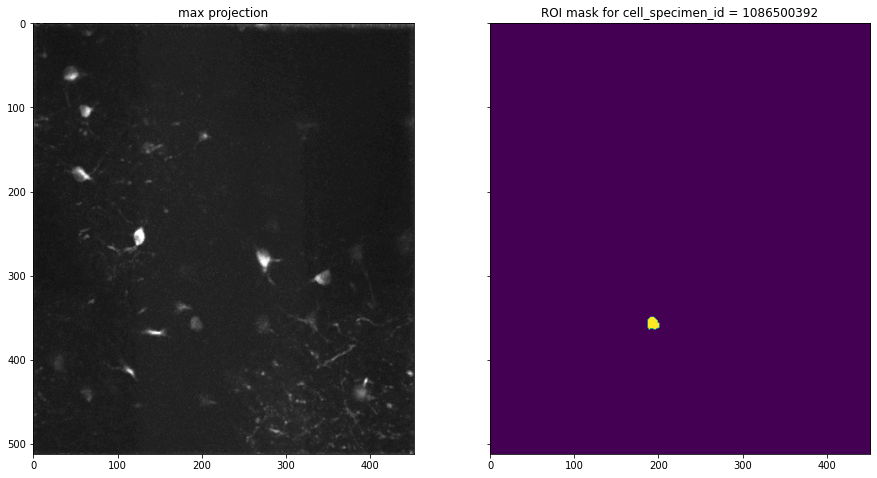

In [122]:
fig, ax = plt.subplots(1, 2, figsize=(15,8), sharex=True, sharey=True)
ax[0].imshow(experiment.max_projection, cmap='gray')
ax[0].set_title('max projection')

cell_specimen_id = experiment.cell_specimen_table.index[6]
ax[1].imshow(experiment.cell_specimen_table.loc[cell_specimen_id]['roi_mask'])
ax[1].set_title('ROI mask for cell_specimen_id = {}'.format(cell_specimen_id))

In [117]:
neural_data = []
for ophys_experiment_id in tqdm(experiments.keys()): #tqdm is a package that shows progress bars for items that are iterated over
    this_experiment = experiments[ophys_experiment_id]
    this_experiment_neural_data = ophys.build_tidy_cell_df(this_experiment)
    
    # add some columns with metadata for the experiment
    metadata_keys = [
        'ophys_experiment_id',
        'ophys_session_id',
        'targeted_structure',
        'imaging_depth',
        'equipment_name',
        'cre_line',
        'mouse_id',
        'sex',
    ]
    for metadata_key in metadata_keys:
        this_experiment_neural_data[metadata_key] = this_experiment.metadata[metadata_key]
        
    # append the data for this experiment to a list
    neural_data.append(this_experiment_neural_data)
    
# concatate the list of dataframes into a single dataframe
neural_data = pd.concat(neural_data)


100%|██████████| 7/7 [00:43<00:00,  6.17s/it]


In [123]:
cell_ids = neural_data['cell_specimen_id'].unique()
print('there are {} unique cells'.format(len(cell_ids)))
print('cell ids are: {}'.format(cell_ids))

there are 78 unique cells
cell ids are: [1086496500 1086496689 1086497129 1086497550 1086500812 1086497908
 1086498071 1086498205 1086498334 1086498461 1086498820 1086498977
 1086499259 1086499316 1086499479 1086499910 1086500121 1086500281
 1086490519 1086490561 1086490598 1086490636 1086490697 1086490748
 1086490784 1086490867 1086490995 1086491035 1086491079 1086491172
 1086491215 1086491256 1086491328 1086491397 1086491469 1086490391
 1086491368 1086490482 1086490526 1086490572 1086490648 1086490689
 1086490777 1086490794 1086490839 1086490936 1086490994 1086491066
 1086491194 1086491263 1086491339 1086491760 1086499499 1086499628
 1086499783 1086499911 1086500092 1086500194 1086500392 1086500633
 1086500583 1086500807 1086501072 1086501262 1086501360 1086501675
 1086502269 1086668247 1086668144 1086668169 1086668188 1086668228
 1086490603 1086490729 1086490846 1086490807 1086490741 1086490751]


In [118]:
single_cell_timeseries = neural_data.query('cell_specimen_id == 1086668169')
single_cell_timeseries.head()

,timestamps,dff,events,filtered_events,cell_roi_id,cell_specimen_id,ophys_experiment_id,ophys_session_id,targeted_structure,imaging_depth,equipment_name,cre_line,mouse_id,sex
0,2.33116,0.043810,0.0,0.0,1080691113,1086668169,1000743008,1000580083,VISp,275,CAM2P.3,Sst-IRES-Cre,489056,M
1,2.36346,0.042470,0.0,0.0,1080691113,1086668169,1000743008,1000580083,VISp,275,CAM2P.3,Sst-IRES-Cre,489056,M
2,2.39576,0.049144,0.0,0.0,1080691113,1086668169,1000743008,1000580083,VISp,275,CAM2P.3,Sst-IRES-Cre,489056,M
3,2.42806,0.023070,0.0,0.0,1080691113,1086668169,1000743008,1000580083,VISp,275,CAM2P.3,Sst-IRES-Cre,489056,M
4,2.46036,0.040942,0.0,0.0,1080691113,1086668169,1000743008,1000580083,VISp,275,CAM2P.3,Sst-IRES-Cre,489056,M


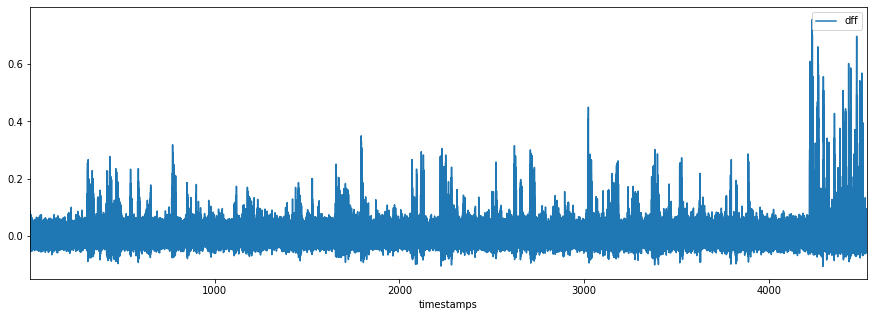

In [81]:
fig, ax = plt.subplots(figsize=(15,5))
single_cell_timeseries.plot(
    x = 'timestamps',
    y = 'dff',
    ax = ax
)

In [113]:
stimulus_table = experiments[ophys_experiment_ids[3]].stimulus_presentations.drop(columns = ['image_set']) # dropping the 'image_set' column to avoid confusion. Image_set column contains a unique string for set of images presented in a session.
stimulus_table.head(10)

,duration,end_frame,image_index,image_name,index,omitted,start_frame,start_time,stop_time,is_change
stimulus_presentations_id,,,,,,,,,,
0,0.25020,18001.0,0,im000,0,False,17986,307.43967,307.68987,False
1,0.25020,18046.0,0,im000,1,False,18031,308.19027,308.44047,False
2,0.25020,18091.0,0,im000,2,False,18076,308.94090,309.19110,False
3,0.25020,18136.0,0,im000,3,False,18121,309.69151,309.94171,False
4,0.25017,18181.0,0,im000,4,False,18166,310.44212,310.69229,False
5,0.25021,18226.0,0,im000,5,False,18211,311.19270,311.44291,False
6,0.25020,18271.0,0,im000,6,False,18256,311.94335,312.19355,False
7,0.25000,NaN,8,omitted,0,True,18300,312.67729,312.92729,False
8,0.25020,18361.0,0,im000,7,False,18346,313.44456,313.69476,False


In [140]:
experiment = experiments[ophys_experiment_ids[2]]
experiment.stimulus_templates

,unwarped,warped
image_name,,
im000,"[[nan, nan, nan, nan, nan, nan, nan, nan, nan,...","[[122, 122, 123, 125, 126, 127, 128, 129, 130,..."
im106,"[[nan, nan, nan, nan, nan, nan, nan, nan, nan,...","[[108, 109, 106, 103, 102, 104, 107, 112, 117,..."
im075,"[[nan, nan, nan, nan, nan, nan, nan, nan, nan,...","[[120, 121, 121, 121, 122, 123, 123, 122, 121,..."
im073,"[[nan, nan, nan, nan, nan, nan, nan, nan, nan,...","[[120, 120, 118, 116, 116, 119, 121, 120, 117,..."
im045,"[[nan, nan, nan, nan, nan, nan, nan, nan, nan,...","[[10, 13, 6, 0, 0, 8, 15, 13, 6, 2, 4, 9, 12, ..."
im054,"[[nan, nan, nan, nan, nan, nan, nan, nan, nan,...","[[124, 125, 127, 130, 133, 134, 136, 138, 140,..."
im031,"[[nan, nan, nan, nan, nan, nan, nan, nan, nan,...","[[233, 234, 244, 253, 253, 244, 237, 239, 246,..."
im035,"[[nan, nan, nan, nan, nan, nan, nan, nan, nan,...","[[178, 181, 189, 198, 200, 198, 196, 199, 205,..."


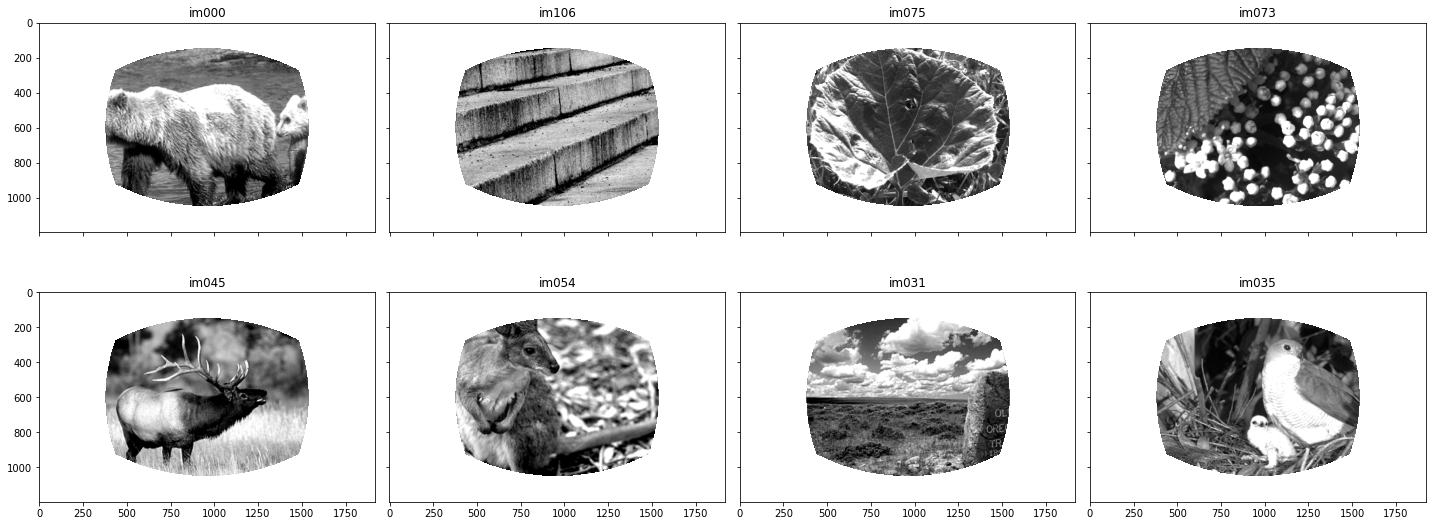

In [141]:
fig, ax = plt.subplots(2,4,figsize = (20,8), sharex = True, sharey=True)
for ii,image_name in enumerate(experiment.stimulus_templates.index):
    ax.flatten()[ii].imshow(experiment.stimulus_templates.loc[image_name]['unwarped'], cmap='gray')
    ax.flatten()[ii].set_title(image_name)
fig.tight_layout()

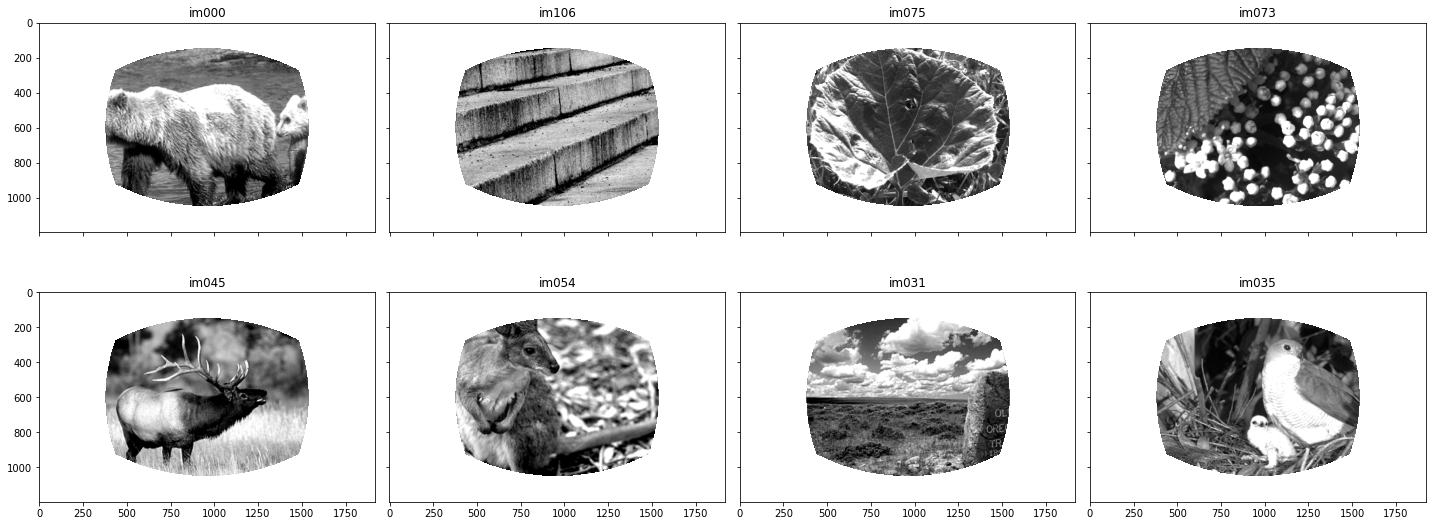

In [86]:
fig, ax = plt.subplots(2,4,figsize = (20,8), sharex = True, sharey=True)
for ii,image_name in enumerate(experiment.stimulus_templates.index):
    ax.flatten()[ii].imshow(experiment.stimulus_templates.loc[image_name]['unwarped'], cmap='gray')
    ax.flatten()[ii].set_title(image_name)
fig.tight_layout()

In [87]:
stimulus_table.query('omitted').head(10)

,duration,end_frame,image_index,image_name,index,omitted,start_frame,start_time,stop_time,is_change
stimulus_presentations_id,,,,,,,,,,
16,0.25,NaN,8,omitted,0,True,18704,319.34023,319.59023,False
63,0.25,NaN,8,omitted,1,True,20819,354.61897,354.86897,False
66,0.25,NaN,8,omitted,2,True,20954,356.87083,357.12083,False
113,0.25,NaN,8,omitted,3,True,23069,392.14961,392.39961,False
117,0.25,NaN,8,omitted,4,True,23249,395.15215,395.40215,False
137,0.25,NaN,8,omitted,5,True,24149,410.16429,410.41429,False
168,0.25,NaN,8,omitted,6,True,25544,433.43326,433.68326,False
243,0.25,NaN,8,omitted,7,True,28918,489.72919,489.97919,False
245,0.25,NaN,8,omitted,8,True,29008,491.23042,491.48042,False


In [109]:
cell_id = cell_ids[0]
etr = mindscope_utilities.event_triggered_response(
    data = neural_data.query('cell_specimen_id == @cell_id'),
    t = 'timestamps',
    y = 'dff',
    event_times = stimulus_table.query('omitted')['start_time'],
    t_before=3,
    t_after=3,
    output_sampling_rate = 50,
)
etr

,time,dff,event_number,event_time
0,-3.00,-0.197642,0,312.67729
1,-2.98,-0.180527,0,312.67729
2,-2.96,-0.111233,0,312.67729
3,-2.94,-0.095873,0,312.67729
4,-2.92,-0.110511,0,312.67729
...,...,...,...,...
63807,2.92,0.024909,211,3890.84711
63808,2.94,0.060907,211,3890.84711
63809,2.96,0.065014,211,3890.84711
63810,2.98,-0.012131,211,3890.84711


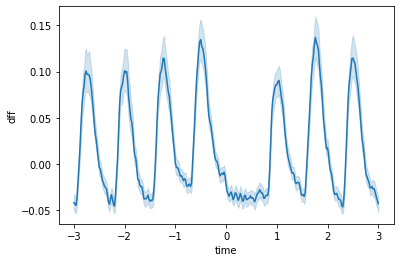

In [89]:
sns.lineplot(
    data=etr,
    x='time',
    y='dff',
    n_boot=500
)

In [99]:
def make_event_triggered_plot(df, x, y, event_query, ax, t_before=3, t_after=3):
    etr = mindscope_utilities.event_triggered_response(
        data = df,
        t = 'timestamps',
        y = y,
        event_times = stimulus_table.query(event_query)['start_time'],
        t_before=t_before,
        t_after=t_before,
        output_sampling_rate = 50,
    )
    sns.lineplot(
        data=etr,
        x=x,
        y=y,
        n_boot=500,
        ax=ax
    )

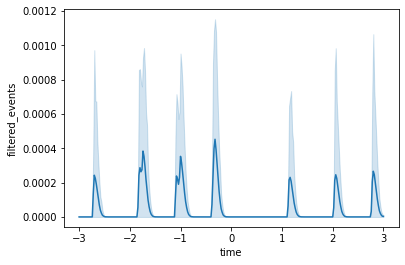

In [134]:
cell_id = experiments[ophys_experiment_ids[1]]cell_ids[50]
fig, ax = plt.subplots()
make_event_triggered_plot(
    df = neural_data.query('cell_specimen_id == @cell_id'), 
    x = 'time', 
    y = 'filtered_events', 
    event_query = 'omitted', 
    ax=ax
)

TypeError: ignored

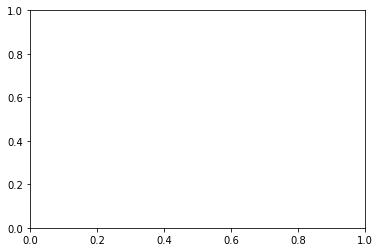

In [130]:
fig, ax = plt.subplots()
for cell_id in cell_ids[0]:
    
    make_event_triggered_plot(
        df = neural_data.query('cell_specimen_id == @cell_id'), 
        x = 'time', 
        y = 'dff', 
        event_query = 'omitted', 
        ax=ax
    )

In [126]:
mean_dff_by_experiment = (
    neural_data
    .groupby(['ophys_experiment_id','timestamps'])['dff']
    .mean()
    .reset_index()
)

In [128]:
mean_dff_by_experiment.head(10)

,ophys_experiment_id,timestamps,dff
0,955276580,3.00886,0.378703
1,955276580,3.04115,0.241370
2,955276580,3.07345,0.255014
3,955276580,3.10574,0.291310
4,955276580,3.13803,0.309121
5,955276580,3.17032,0.259315
6,955276580,3.20262,0.240861
7,955276580,3.23491,0.292867
8,955276580,3.26720,0.261403
9,955276580,3.29949,0.289346



100%|██████████| 7/7 [00:29<00:00,  4.20s/it]


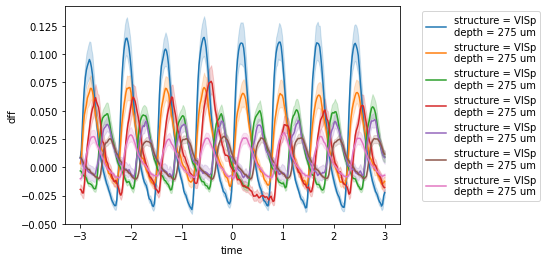

In [135]:
# set up a new figure and axis
fig, ax = plt.subplots()

# make an empty list that we will fill with strings for the legend
legend_text = []

# iterate over every `ophys_experiment_id`
for ophys_experiment_id in tqdm(ophys_experiment_ids):
    
    make_event_triggered_plot(
        df = mean_dff_by_experiment.query('ophys_experiment_id == @ophys_experiment_id'), 
        x = 'time', 
        y = 'dff', 
        event_query = 'omitted', 
        ax=ax
    )
    
    # get some metadata to add to the legend
    this_exp = neural_data.query('ophys_experiment_id == @ophys_experiment_id')
    structure = this_exp['targeted_structure'].iloc[0]
    depth = this_exp['imaging_depth'].iloc[0]

    # append a string to our list of legend text
    legend_text.append('structure = {}\ndepth = {} um'.format(structure, depth))
    
# Put the legend out of the figure
plt.legend(legend_text, bbox_to_anchor=(1.05, 1))

In [137]:
# set up a new figure and axis
fig, ax = plt.subplots()

# make an empty list that we will fill with strings for the legend
legend_text = []

# iterate over every `ophys_experiment_id`
for cell_id in tqdm(cell_ids, size=10, replace=False)):    
    make_event_triggered_plot(
        df = mean_dff_by_experiment.query('ophys_experiment_id == 977935606'), 
        x = 'time', 
        y = 'dff', 
        event_query = 'omitted', 
        ax=ax
    )

    # get some metadata to add to the legend
    this_exp = neural_data.query('ophys_experiment_id == @ophys_experiment_id')
    structure = this_exp['targeted_structure'].iloc[0]
    depth = this_exp['imaging_depth'].iloc[0]

    # append a string to our list of legend text
    legend_text.append('structure = {}\ndepth = {} um'.format(structure, depth))
    
# Put the legend out of the figure
plt.legend(legend_text, bbox_to_anchor=(1.05, 1))

SyntaxError: ignored